In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import xgboost as xgb
import pickle as pkl

# Importing Required Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
f1 = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/Friday1.csv")
f2 = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/Friday2.csv")
f3 = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/Friday3.csv")
th1 = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/Thursday1.csv")
th2 = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/Thursday2.csv")
tu1 = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/Tuesday1.csv")
wed = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/Wednesday.csv")
mon = pd.read_csv("/content/drive/MyDrive/AIDS/MachineLearningCVE/monday.csv")

In [ ]:
df = pd.concat([f1, f2, f3, th1, th2, tu1, wed, mon], axis=0)
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529913,443,18738,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
529914,53,60797,2,2,80,156,40,40,40.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
529915,53,154,2,2,64,96,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
529916,53,155,2,2,80,144,40,40,40.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Cleaning Data

In [ ]:
df.drop_duplicates(inplace = True)
df.shape

(2522362, 79)

In [ ]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop NaN values
df.dropna(axis=0, inplace=True)

df.shape

(2520798, 79)

In [ ]:
#stripping column names

df.rename(columns = lambda x: x.strip(), inplace = True)

In [ ]:
df['Label'].value_counts()

BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

In [ ]:
# Define the mapping
mapping = {
    'BENIGN' : 'BENIGN',
    'DoS Hulk': 'DoS/DDoS',
    'DDoS': 'DoS/DDoS',
    'DoS GoldenEye': 'DoS/DDoS',
    'DoS slowloris': 'DoS/DDoS',
    'DoS Slowhttptest': 'DoS/DDoS',
    'PortScan':'PortScan',
    'Web Attack � Brute Force': 'Brute Force',
    'FTP-Patator' : 'Brute Force',
    'SSH-Patator' : 'Brute Force',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Heartbleed' : 'Web Attack',
    'Infiltration' : 'Bot',
    'Bot': 'Bot'
}
# # Apply the mapping
df['Label'] = df['Label'].map(mapping).fillna('Other')

In [ ]:
df['Label'].value_counts()

BENIGN         2095057
DoS/DDoS        321759
PortScan         90694
Brute Force      10620
Bot               1984
Web Attack         684
Name: Label, dtype: int64

# Analyzing Data

In [ ]:
import seaborn as sns

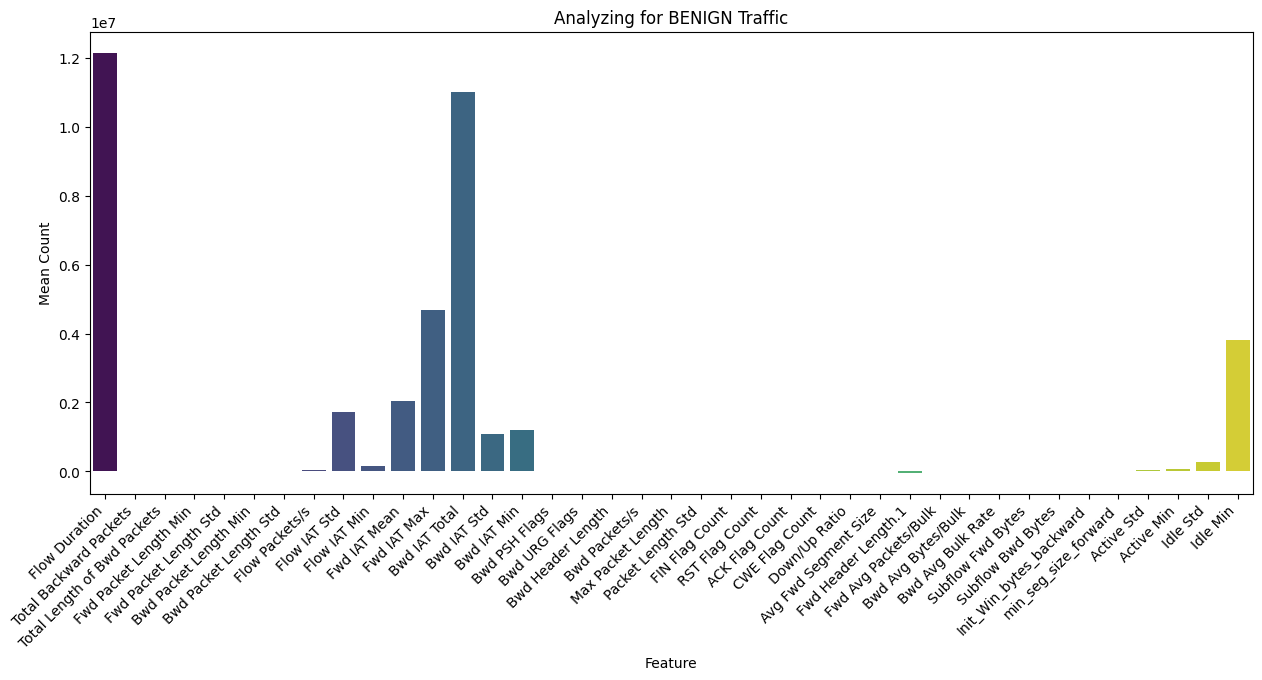

In [ ]:
# Filter rows with the 'Benign' label
benign_data = df[df['Label'] == 'BENIGN']

# Extract features
features = benign_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = benign_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for BENIGN Traffic')
plt.show()

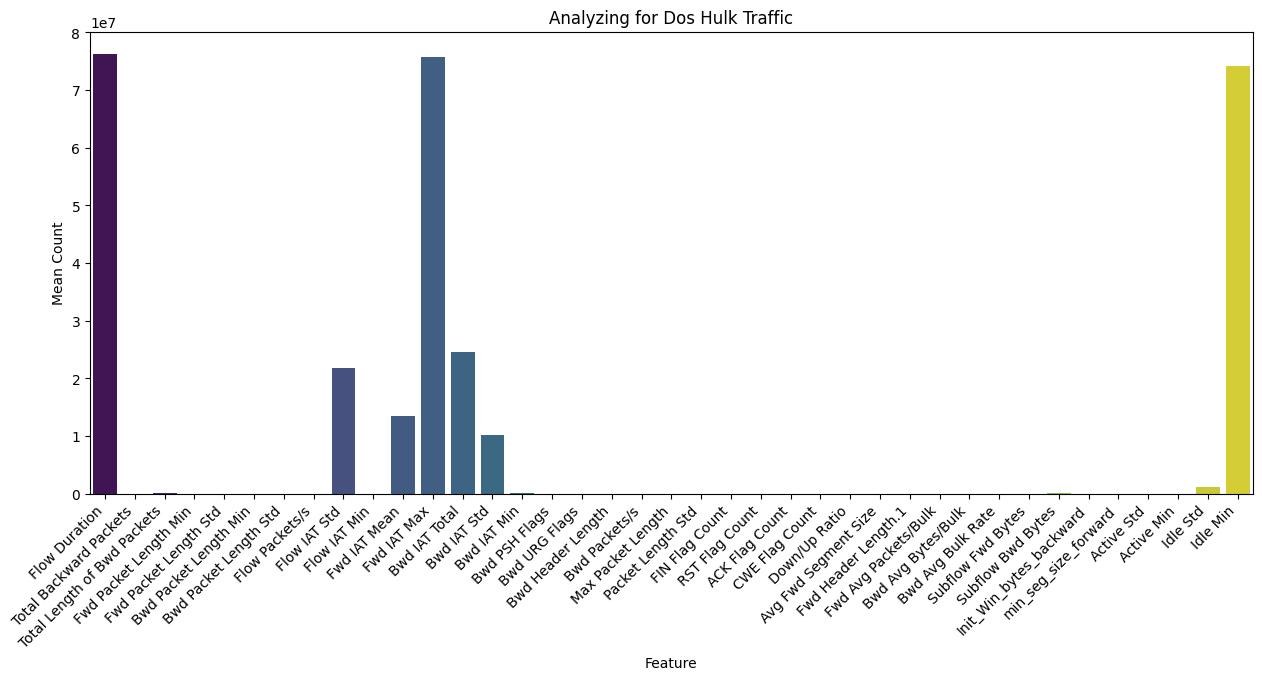

In [ ]:
# Filter rows with the 'DoS Hulk' label
Dos_Hulk_data = df[df['Label'] == 'DoS Hulk']

# Extract features
features = Dos_Hulk_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = Dos_Hulk_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for Dos Hulk Traffic')
plt.show()

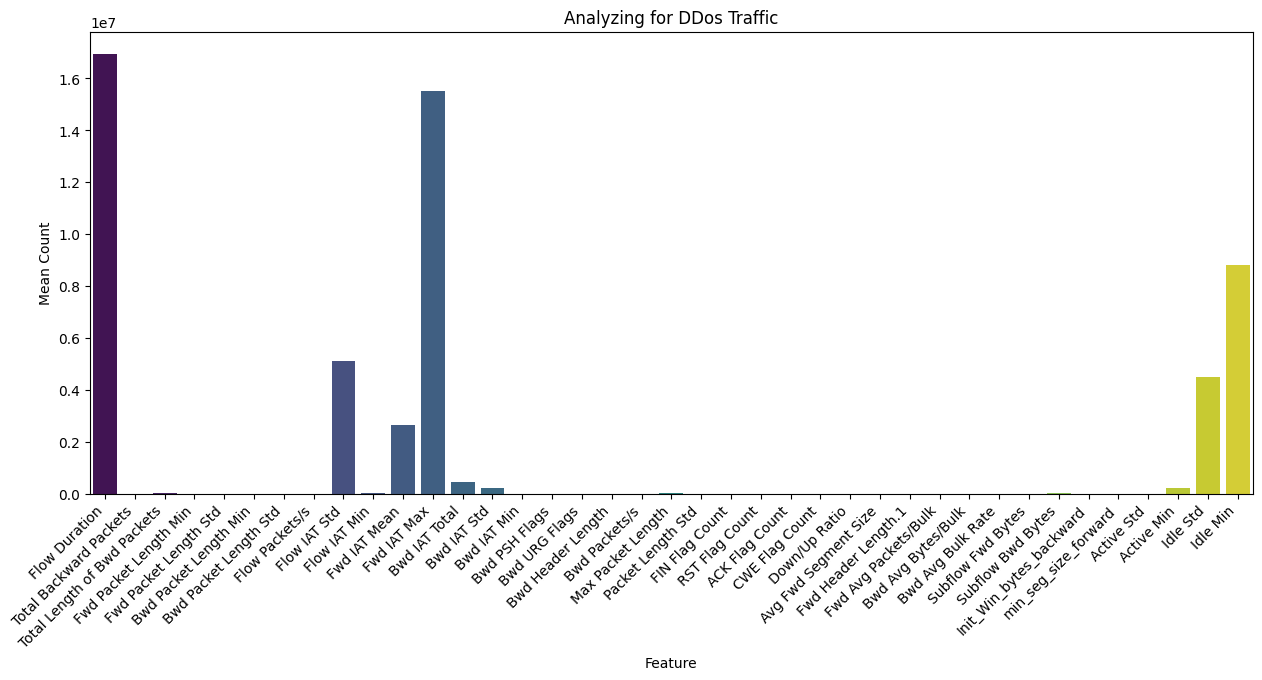

In [ ]:
# Filter rows with the 'DDoS' label
DDos_data = df[df['Label'] == 'DDoS']

# Extract features
features = DDos_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = DDos_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for DDos Traffic')
plt.show()

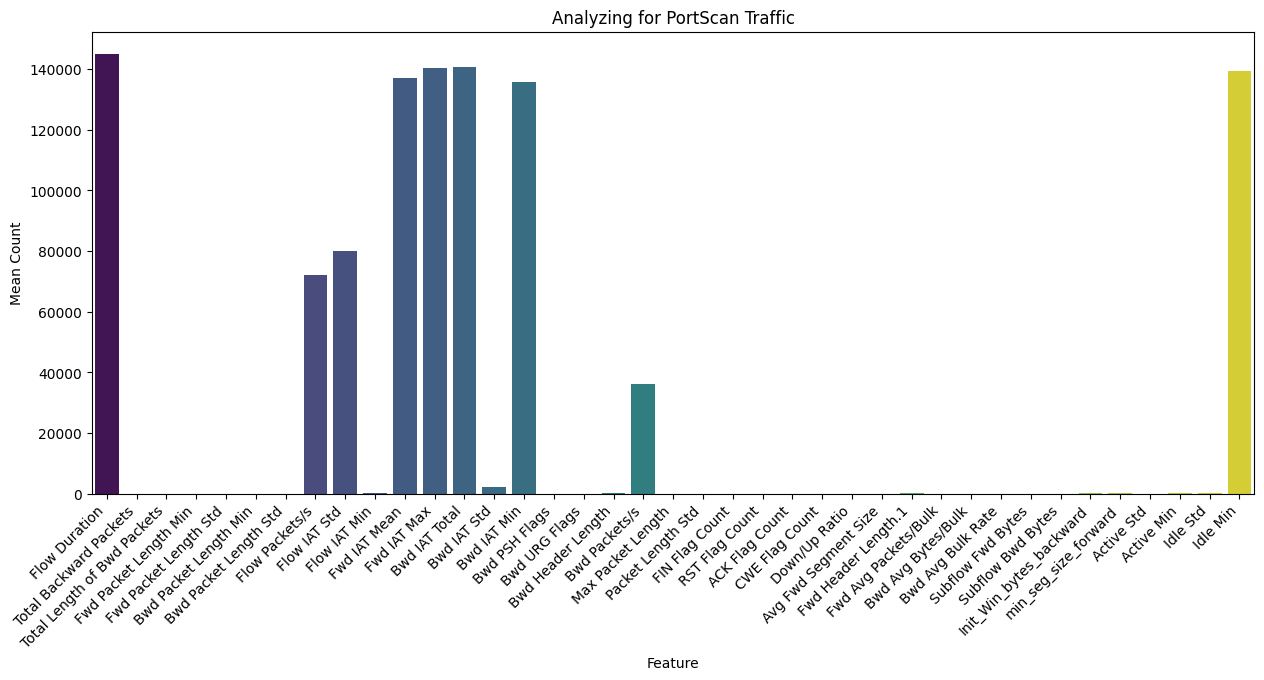

In [ ]:
# Filter rows with the 'PortScan' label
PortScan_data = df[df['Label'] == 'PortScan']

# Extract features
features = PortScan_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = PortScan_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for PortScan Traffic')
plt.show()

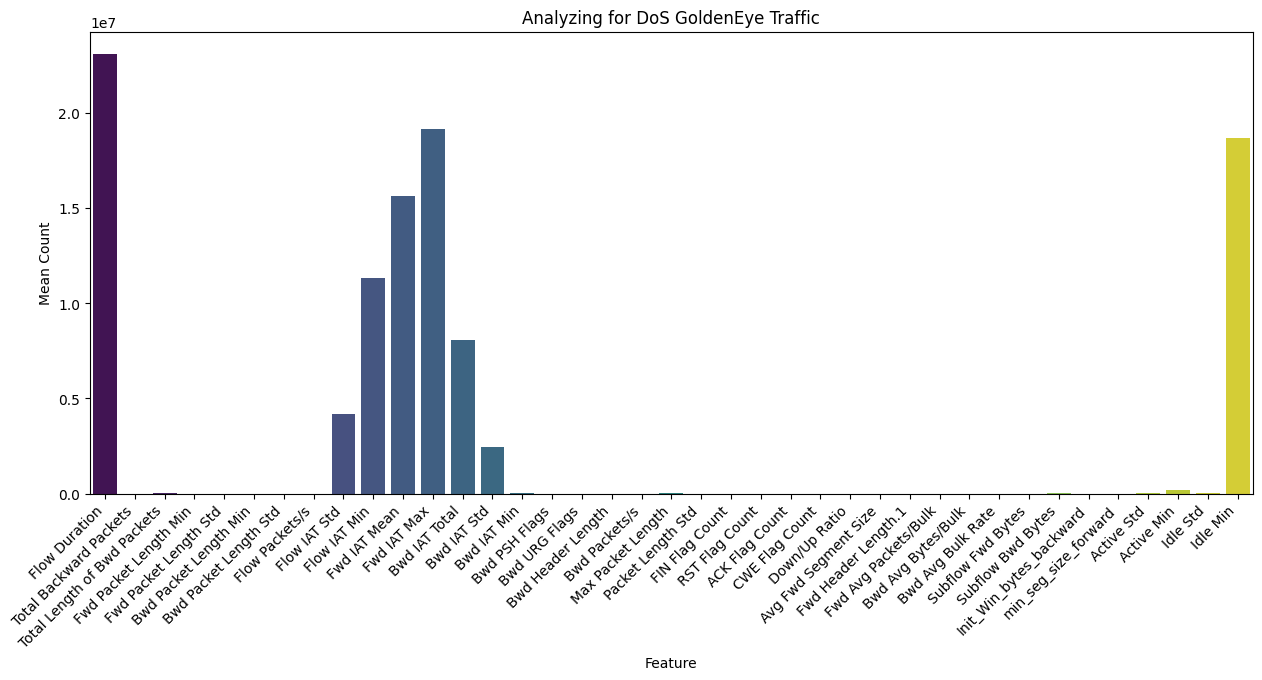

In [ ]:
# Filter rows with the 'DoS GoldenEye' label
DoS_GoldenEye_data = df[df['Label'] == 'DoS GoldenEye']

# Extract features
features = DoS_GoldenEye_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = DoS_GoldenEye_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for DoS GoldenEye Traffic')
plt.show()

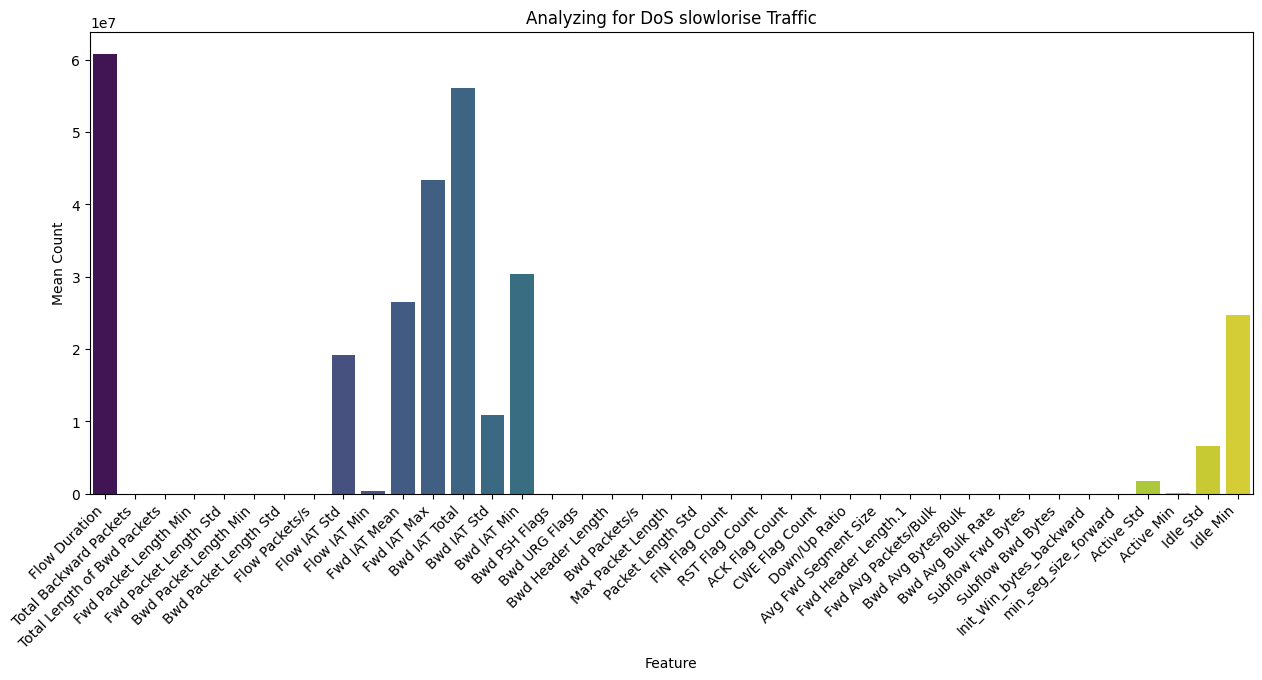

In [ ]:
# Filter rows with the 'DoS slowloris' label
DoS_slowloris_data = df[df['Label'] == 'DoS slowloris']

# Extract features
features = DoS_slowloris_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = DoS_slowloris_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for DoS slowlorise Traffic')
plt.show()

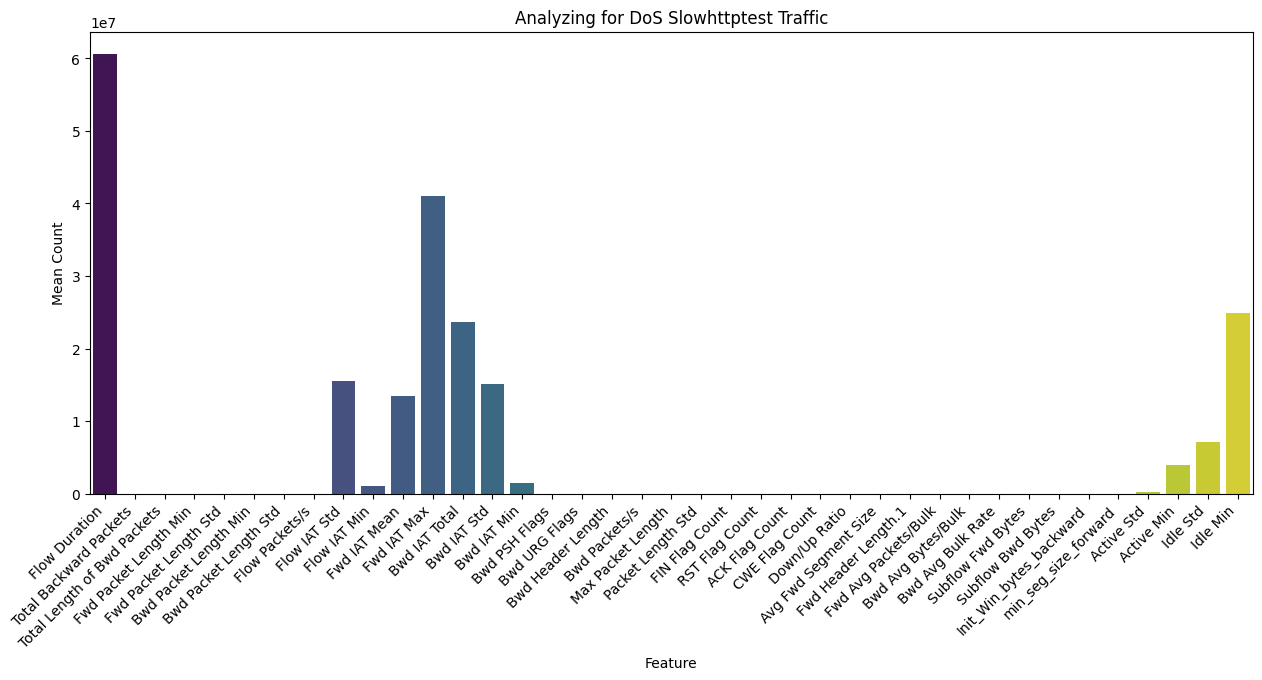

In [ ]:
# Filter rows with the 'DoS Slowhttptest' label
DoS_Slowhttptest_data = df[df['Label'] == 'DoS Slowhttptest']

# Extract features
features = DoS_Slowhttptest_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = DoS_Slowhttptest_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for DoS Slowhttptest Traffic')
plt.show()

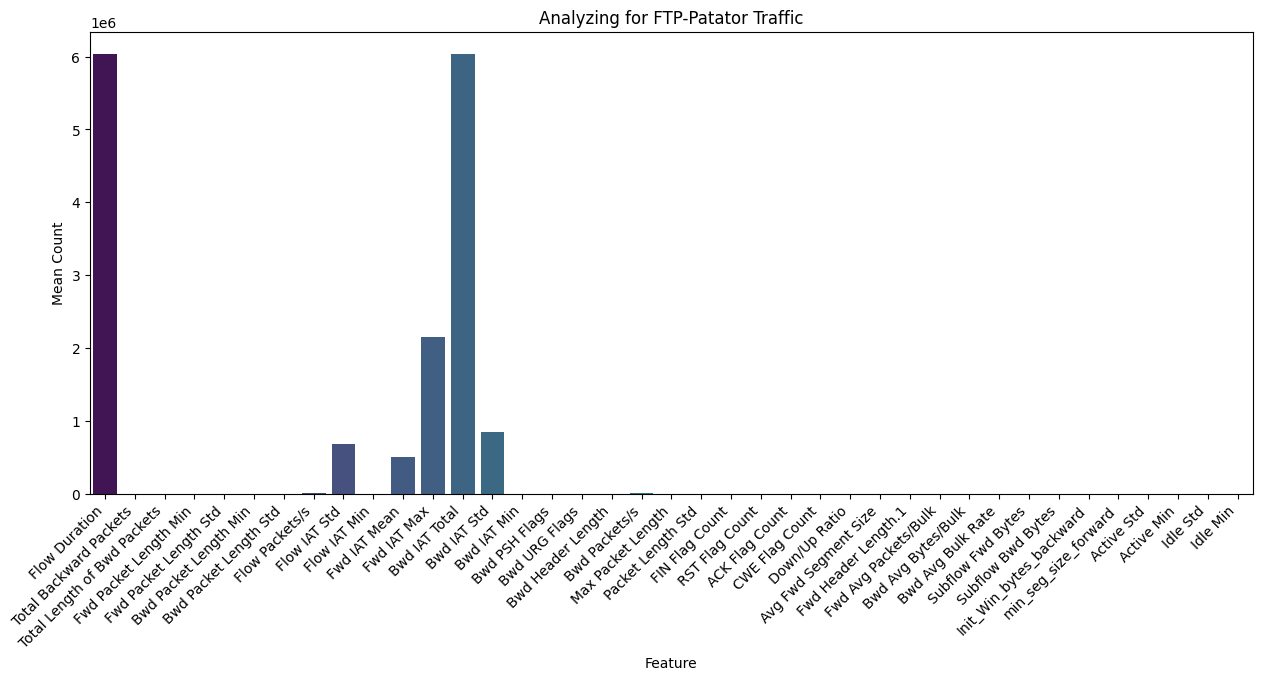

In [ ]:
# Filter rows with the 'FTP-Patator' label
FTP_Patator_data = df[df['Label'] == 'FTP-Patator']

# Extract features
features = FTP_Patator_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = FTP_Patator_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for FTP-Patator Traffic')
plt.show()

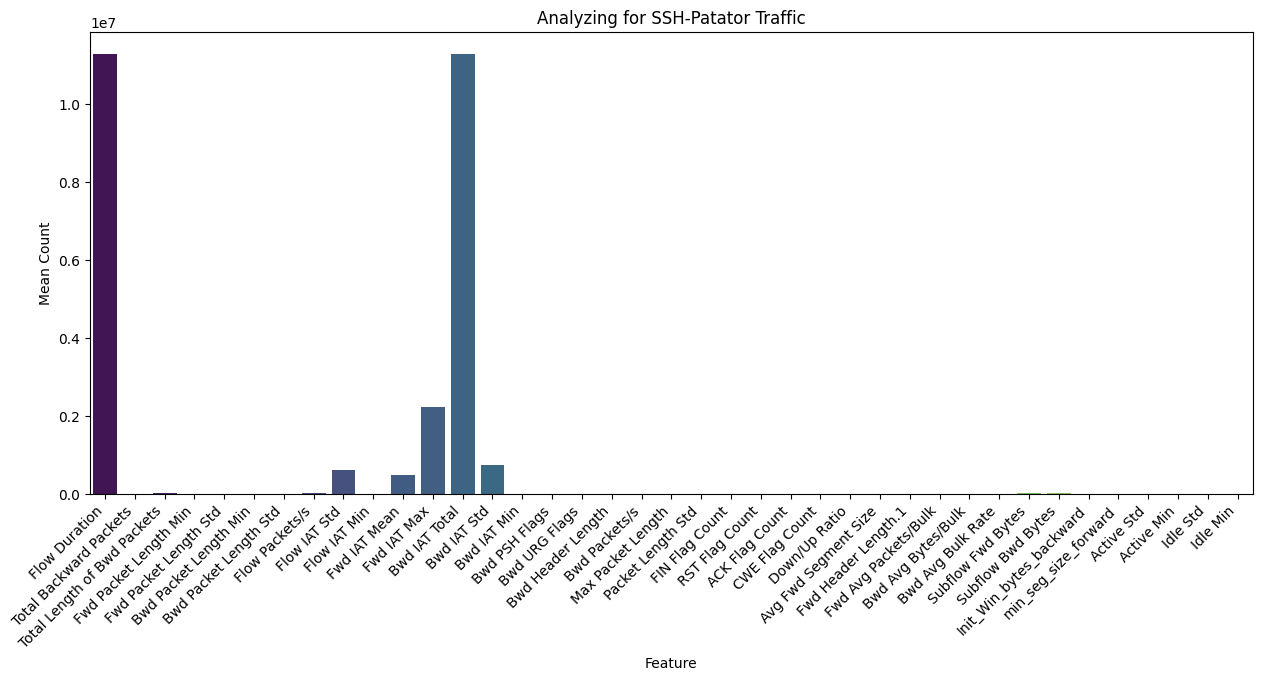

In [ ]:
# Filter rows with the 'SSH-Patator' label
SSH_Patator_data = df[df['Label'] == 'SSH-Patator']

# Extract features
features = SSH_Patator_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = SSH_Patator_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for SSH-Patator Traffic')
plt.show()

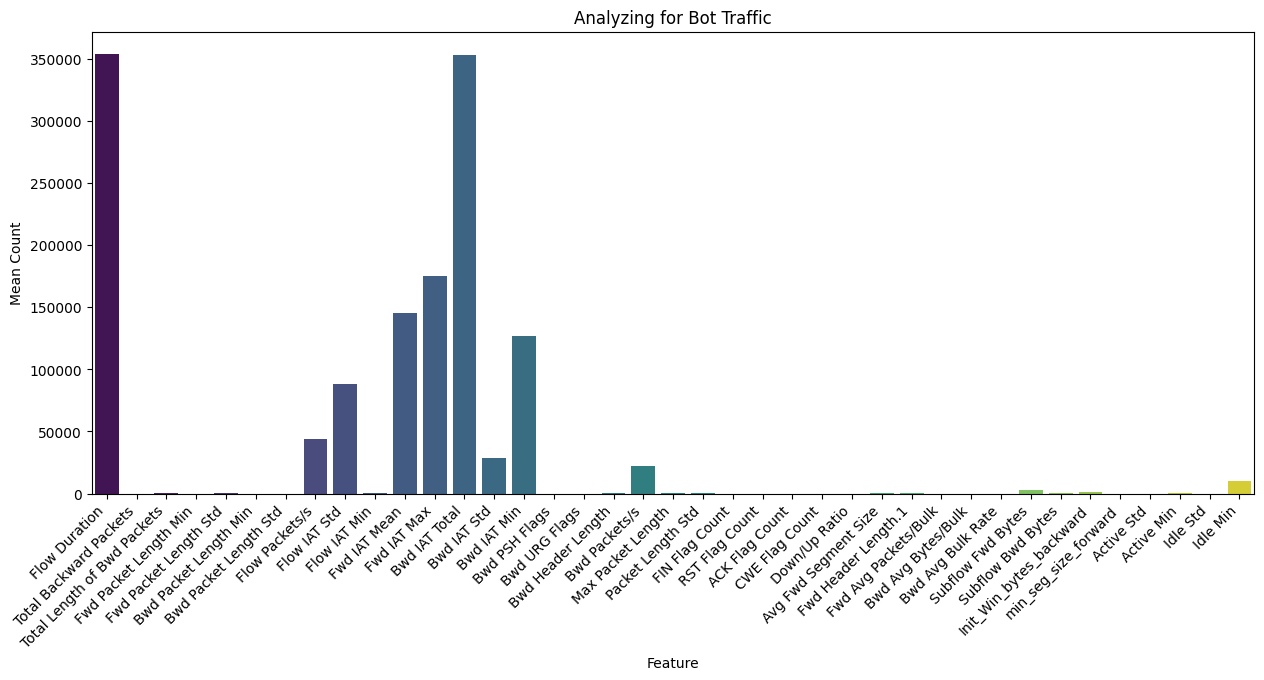

In [ ]:
# Filter rows with the 'Bot' label
Bot_data = df[df['Label'] == 'Bot']

# Extract features
features = Bot_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = Bot_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for Bot Traffic')
plt.show()

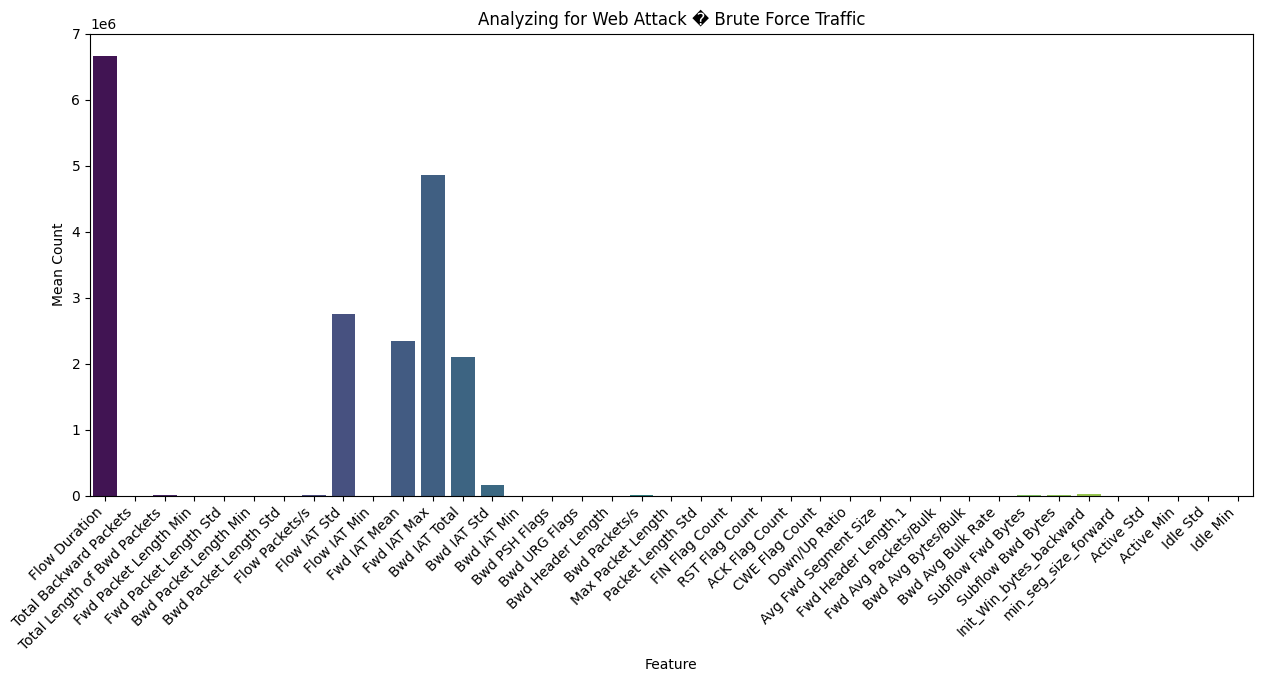

In [ ]:
# Filter rows with the 'Web Attack � Brute Force' label
Brute_Force_data = df[df['Label'] == 'Web Attack � Brute Force']

# Extract features
features = Brute_Force_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = Brute_Force_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for Web Attack � Brute Force Traffic')
plt.show()

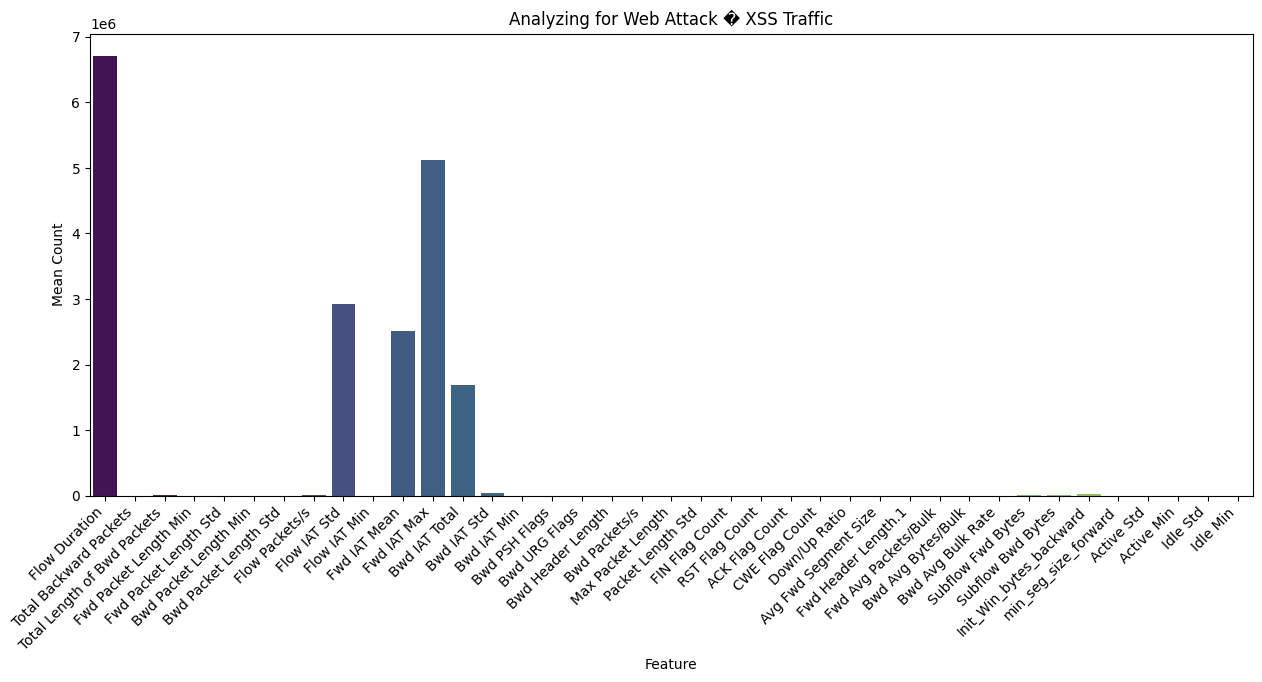

In [ ]:
# Filter rows with the 'Web Attack � XSS' label
XSS_data = df[df['Label'] == 'Web Attack � XSS']

# Extract features
features = XSS_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = XSS_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for Web Attack � XSS Traffic')
plt.show()

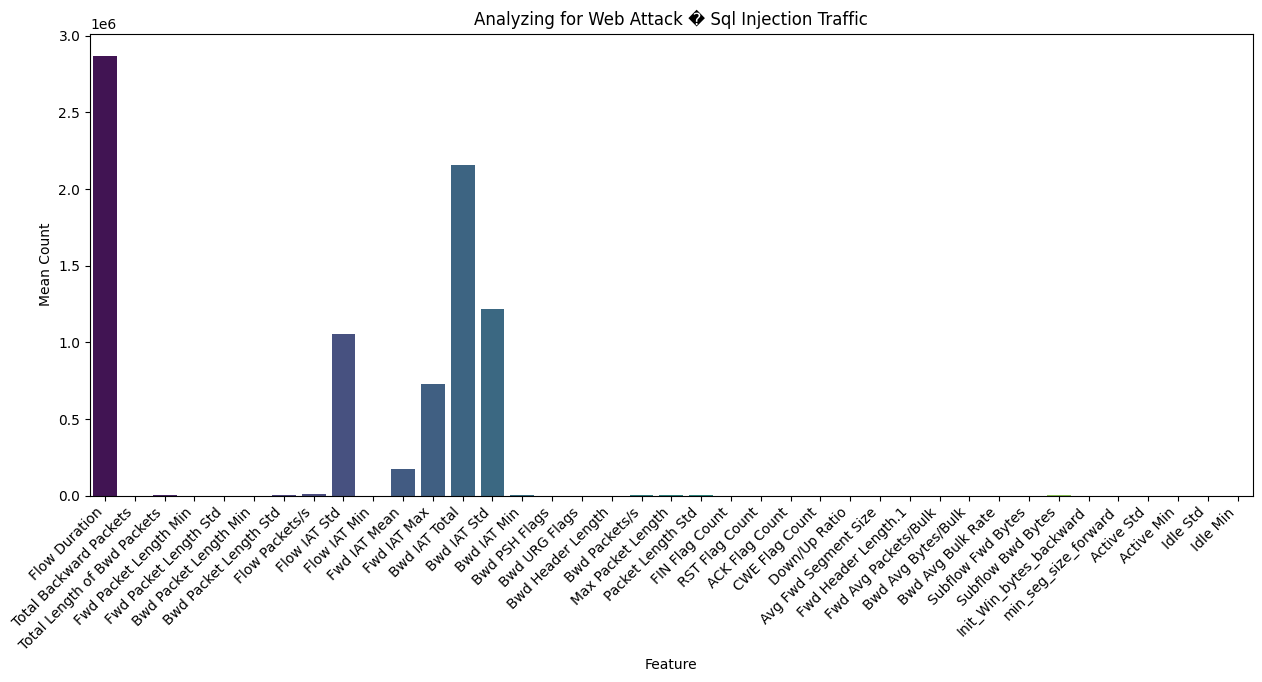

In [ ]:
# Filter rows with the 'Web Attack � Sql Injection' label
Sql_Injection_data = df[df['Label'] == 'Web Attack � Sql Injection']

# Extract features
features = Sql_Injection_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = Sql_Injection_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for Web Attack � Sql Injection Traffic')
plt.show()

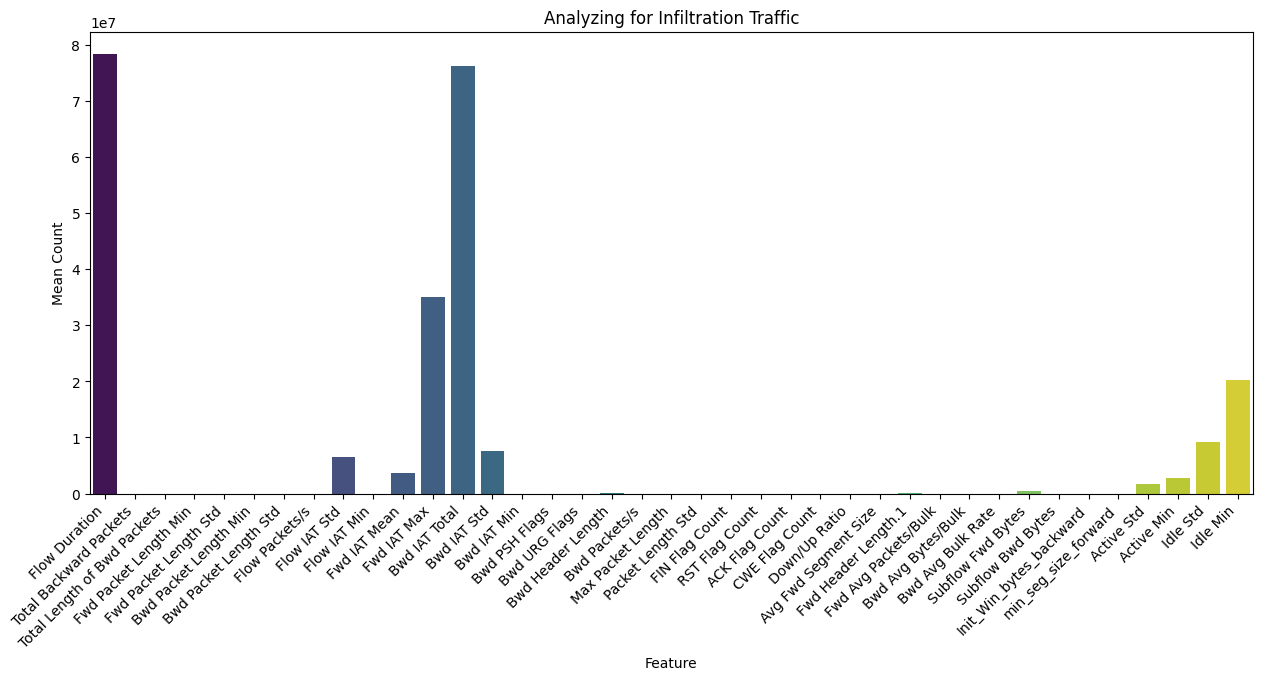

In [ ]:
# Filter rows with the 'Infiltration' label
Infiltration_data = df[df['Label'] == 'Infiltration']

# Extract features
features = Infiltration_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = Infiltration_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for Infiltration Traffic')
plt.show()

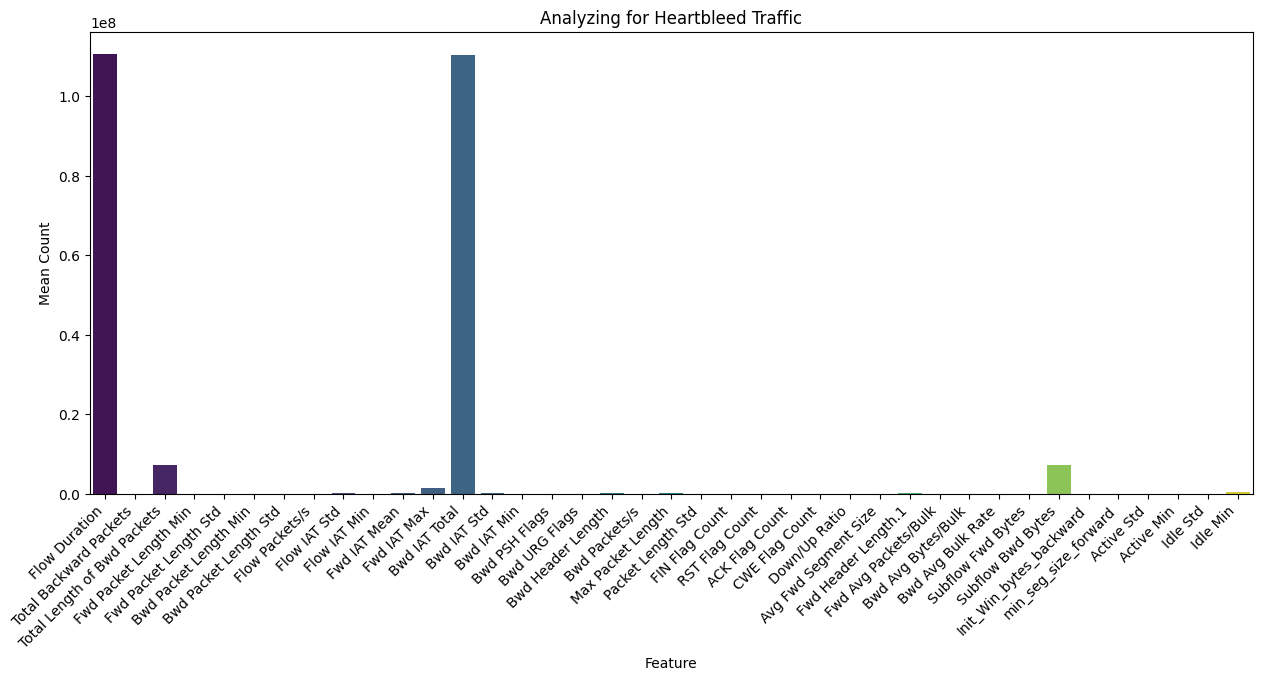

In [ ]:
# Filter rows with the 'Heartbleed' label
Heartbleed_data = df[df['Label'] == 'Heartbleed']

# Extract features
features = Heartbleed_data.columns[1::2]

# Create lists to store feature names and their mean counts
feature_names = []
mean_counts = []

# Calculate mean count for each feature
for feature in features:
    mean_count = Heartbleed_data[feature].mean()
    feature_names.append(feature)
    mean_counts.append(mean_count)

# Create a DataFrame from the lists
mean_counts_df = pd.DataFrame({'Feature': feature_names, 'Mean Count': mean_counts})

# Create a count plot for mean counts
plt.figure(figsize=(15, 6))
sns.barplot(x='Feature', y='Mean Count', data=mean_counts_df, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Analyzing for Heartbleed Traffic')
plt.show()

# Data Preprocessing

In [ ]:
#splitting Data into x(independent) and y(dependent)

x = df.iloc[:, :-1]
y = df["Label"]

In [ ]:
# import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Convert y to numeric labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

# Training Model


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np


# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), selector(dtype_exclude="category")),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('label_encoder', LabelEncoder())
        ]), selector(dtype_include="category"))
    ])

# Define the pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('sampler1', RandomOverSampler()),
    ('sampler', RandomUnderSampler()),
    ('classifier', XGBClassifier(tree_method='hist', device='cuda',objective= 'multi:softmax',  eval_metric = 'mlogloss',  num_class = len(np.unique(y))))
])

pipeline.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bd6ee28b940>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('label_encoder',
                                                                   LabelEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bd6...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=6,
                               num_parallel_tree=None, ...))])

In [ ]:
# Make predictions
preds = pipeline.predict(X_val)

# Evaluate model
accuracy = sum(preds == y_val) / len(y_val)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:23:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9885631545541098


# Saving Model

In [ ]:
import joblib

# Save the pipeline
joblib.dump(pipeline, '/content/drive/MyDrive/AIDS/MachineLearningCVE/xgboost_model_8.pkl')
# Also save label encoder to transform labels back when needed
encoder_filename = "/content/drive/MyDrive/AIDS/MachineLearningCVE/label_encoder_1.pkl"
joblib.dump(label_encoder, encoder_filename)

['/content/drive/MyDrive/AIDS/MachineLearningCVE/xgboost_model_8.pkl']